In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import mlp
import importlib
from sklearn.model_selection import train_test_split
import sklearn
from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
x_train = np.loadtxt('preprocessed/x_train.csv', delimiter=',')
y_train = np.loadtxt('preprocessed/y_train.csv', delimiter=',')

x_train_resampled = np.loadtxt('preprocessed/x_train_resampled.csv', delimiter=',')
y_train_resampled = np.loadtxt('preprocessed/y_train_resampled.csv', delimiter=',')

x_valid = np.loadtxt('preprocessed/x_valid.csv', delimiter=',')
y_valid = np.loadtxt('preprocessed/y_valid.csv', delimiter=',')

x_test = np.loadtxt('preprocessed/x_test.csv', delimiter=',')
y_test = np.loadtxt('preprocessed/y_test.csv', delimiter=',')

In [4]:
x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).float().unsqueeze(1).to(device)

x_train_resampled = torch.from_numpy(x_train_resampled).float().to(device)
y_train_resampled = torch.from_numpy(y_train_resampled).float().unsqueeze(1).to(device)

x_valid = torch.from_numpy(x_valid).float().to(device)
y_valid = torch.from_numpy(y_valid).float().unsqueeze(1).to(device)

x_test = torch.from_numpy(x_test).float().to(device)
y_test = torch.from_numpy(y_test).float().unsqueeze(1).to(device)

In [5]:
size_feature = x_train_resampled.shape[1]
size_train = x_train_resampled.shape[0]
size_test = x_test.shape[0]
print(f'feature size: {size_feature} | train size: {size_train} | test size: {size_test}')

feature size: 44 | train size: 135452 | test size: 9568


In [6]:
def train(model, x_train, y_train, x_valid, y_valid, config):
    loader_train = DataLoader(list(zip(x_train, y_train)), shuffle=True, batch_size=config['batch_size'])
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['decay'])
    criterion = torch.nn.BCEWithLogitsLoss()

    loss_record_train = []
    loss_record_valid = []

    for epoch in range(config['num_epoch']):
        model.train()
        for i, (x, y) in enumerate(loader_train):
            out = model(x)
            loss = criterion(out, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        out_train = model(x_train)
        loss_train = criterion(out_train, y_train).detach().item()
        loss_record_train.append(loss_train)
        yhat_train = torch.round(torch.sigmoid(out_train)).detach()
        acurracy_train = sklearn.metrics.accuracy_score(y_train.cpu().numpy(), yhat_train.cpu().numpy())

        out_valid = model(x_valid)
        loss_valid = criterion(out_valid, y_valid).detach().item()
        loss_record_valid.append(loss_valid)
        yhat_valid = torch.round(torch.sigmoid(out_valid)).detach()
        acurracy_valid = sklearn.metrics.accuracy_score(y_valid.cpu().numpy(), yhat_valid.cpu().numpy())

        print(f'\r[Info] epoch: {epoch + 1}/{config["num_epoch"]} | training loss: {loss_train} | training accuracy: {acurracy_train} | validation loss: {loss_valid} | validation accuracy: {acurracy_valid}', end='')
    print('\n[Info] Done')
    return loss_record_train, loss_record_valid

def cross_validation(x_train, y_train, x_valid, y_valid, config):
    model = mlp.MLP(config['size_feature'], 1, config['hidden_layers'], config['act'], with_bn=config['with_bn'], with_do=config['with_do']).to(device)
    loss_record_train, loss_record_valid = train(model, x_train, y_train, x_valid, y_valid, config)
    plt.plot(loss_record_train, label='training')
    plt.plot(loss_record_valid, label='validation')
    plt.legend()
    plt.show()
    return loss_record_valid[-1]

## Explore different hidden layers configuration

### Impact of hidden unit size

In [7]:
config = dict(
    size_feature = size_feature,
    act = 'tanh',
    with_do = False,
    with_bn = False,
    batch_size = 512,
    num_epoch = 100,
    lr = 1e-3,
    decay = 1e-6,
)

[Info] epoch: 100/100 | training loss: 0.5101673603057861 | training accuracy: 0.7975002214806721 | validation loss: 0.5713691115379333 | validation accuracy: 0.7237378488554406
[Info] Done


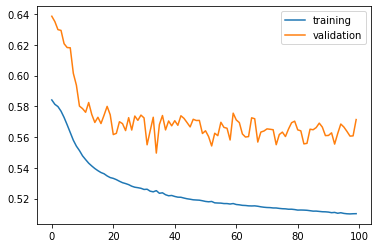

In [8]:
config['hidden_layers'] = [32]
loss_valid = cross_validation(x_train_resampled, y_train_resampled, x_valid, y_valid, config)

[Info] epoch: 100/100 | training loss: 0.47096315026283264 | training accuracy: 0.8439963972477336 | validation loss: 0.5439946055412292 | validation accuracy: 0.7576042646597679
[Info] Done


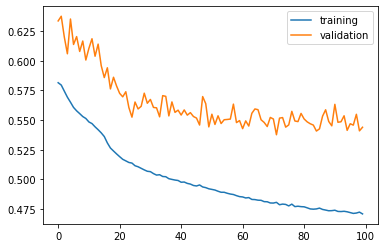

In [9]:
config['hidden_layers'] = [128]
loss_valid = cross_validation(x_train_resampled, y_train_resampled, x_valid, y_valid, config)

[Info] epoch: 100/100 | training loss: 0.4344640076160431 | training accuracy: 0.8837152644479225 | validation loss: 0.5348176956176758 | validation accuracy: 0.7683704400543535
[Info] Done


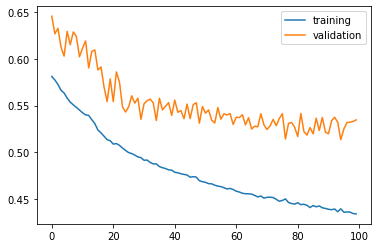

In [10]:
config['hidden_layers'] = [512]
loss_valid = cross_validation(x_train_resampled, y_train_resampled, x_valid, y_valid, config)

As the size of the hidden unit increases, the model overfits more, which makes sense. However, the training and validation accuracies both increase. There is a tradeoff between overfitting and accuracy.

### Impact of the number of hidden layers

[Info] epoch: 100/100 | training loss: 0.37161850929260254 | training accuracy: 0.9431311460886513 | validation loss: 0.5141233205795288 | validation accuracy: 0.7932476220340755
[Info] Done


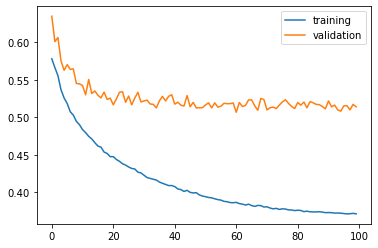

In [11]:
config['hidden_layers'] = [512] * 2
loss_valid = cross_validation(x_train_resampled, y_train_resampled, x_valid, y_valid, config)

[Info] epoch: 100/100 | training loss: 0.362964928150177 | training accuracy: 0.9500118123025131 | validation loss: 0.5187869071960449 | validation accuracy: 0.7903208947423435
[Info] Done


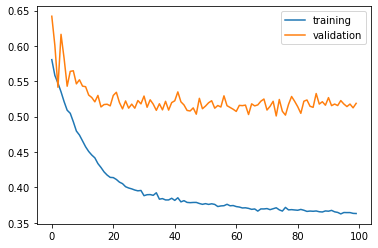

In [12]:
config['hidden_layers'] = [512] * 4
loss_valid = cross_validation(x_train_resampled, y_train_resampled, x_valid, y_valid, config)

[Info] epoch: 100/100 | training loss: 0.49918535351753235 | training accuracy: 0.8098883737412516 | validation loss: 0.5709878206253052 | validation accuracy: 0.748824082784572
[Info] Done


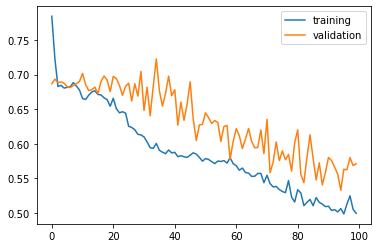

In [13]:
config['hidden_layers'] = [512] * 8
loss_valid = cross_validation(x_train_resampled, y_train_resampled, x_valid, y_valid, config)

Having more layers helps the model to converge better but also increases the chance of overfitting. There is a tradeoff we need to make.

### Impact of the activation function (ReLU vs. Tanh)

[Info] epoch: 100/100 | training loss: 0.36614739894866943 | training accuracy: 0.9466526887753596 | validation loss: 0.5156323909759521 | validation accuracy: 0.7933521480087802
[Info] Done


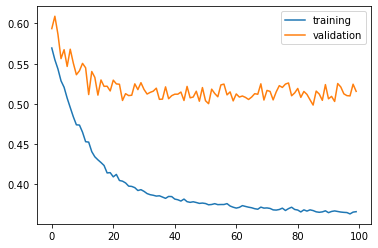

In [14]:
config['hidden_layers'] = [512] * 4
config['act'] = 'tanh'
loss_valid = cross_validation(x_train_resampled, y_train_resampled, x_valid, y_valid, config)

[Info] epoch: 100/100 | training loss: 0.6931471824645996 | training accuracy: 0.5 | validation loss: 0.6931472420692444 | validation accuracy: 0.8876345771924323
[Info] Done


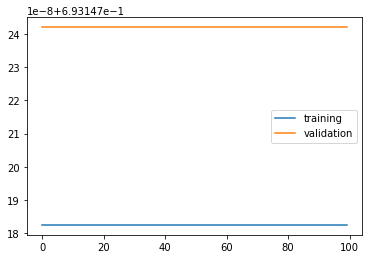

In [15]:
config['act'] = 'relu'
loss_valid = cross_validation(x_train_resampled, y_train_resampled, x_valid, y_valid, config)

Tanh performs better in the above experiment. We will use Tanh from now on.

## Impact of Dropout layer

[Info] epoch: 100/100 | training loss: 0.502040684223175 | training accuracy: 0.8147757139060331 | validation loss: 0.575228214263916 | validation accuracy: 0.7102539981185324
[Info] Done


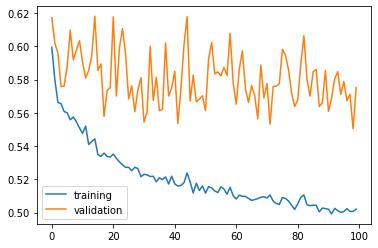

In [16]:
config['act'] = 'tanh'
config['with_do'] = True
loss_valid = cross_validation(x_train_resampled, y_train_resampled, x_valid, y_valid, config)

As expected, dropout layer significantly reduces overfitting. I am going to keep it.

## Impact of BatchNorm

[Info] epoch: 100/100 | training loss: 0.4934910535812378 | training accuracy: 0.8334243864985382 | validation loss: 0.5576003789901733 | validation accuracy: 0.7345040242500261
[Info] Done


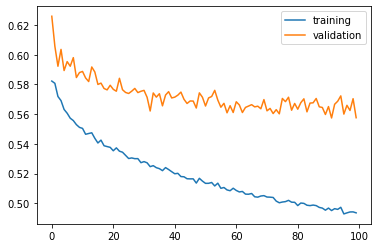

In [17]:
config['with_bn'] = True
loss_valid = cross_validation(x_train_resampled, y_train_resampled, x_valid, y_valid, config)

## Evaluate the best model on test data

[Info] epoch: 500/500 | training loss: 0.3495081067085266 | training accuracy: 0.9633818622094912 | validation loss: 0.5193191766738892 | validation accuracy: 0.7911789297658863
[Info] Done


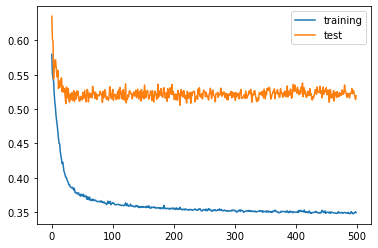

In [19]:
best_config = dict(
    size_feature = size_feature,
    act = 'tanh',
    hidden_layers = [512] * 4,
    with_do = True,
    with_bn = True,
    batch_size = 512,
    num_epoch = 500,
    lr = 1e-3,
    decay = 1e-6,
)
best_model = mlp.MLP(best_config['size_feature'], 1, best_config['hidden_layers'], best_config['act']).to(device)
loss_record_train, loss_record_valid = train(best_model, x_train_resampled, y_train_resampled, x_test, y_test, best_config)
plt.plot(loss_record_train, label='training')
plt.plot(loss_record_valid, label='test')
plt.legend()
plt.show()

In [20]:
best_model.eval()
yhat_test = torch.round(torch.sigmoid(best_model(x_test)))
yhat_test_ = yhat_test.detach().cpu().numpy()
y_test_ = y_test.cpu().numpy()
print(sklearn.metrics.classification_report(y_test_, yhat_test_))

              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88      8432
         1.0       0.18      0.21      0.19      1136

    accuracy                           0.79      9568
   macro avg       0.53      0.54      0.54      9568
weighted avg       0.81      0.79      0.80      9568



In [21]:
print(f'roc auc score: {sklearn.metrics.roc_auc_score(y_test_, yhat_test_)}')

roc auc score: 0.5402875030066547


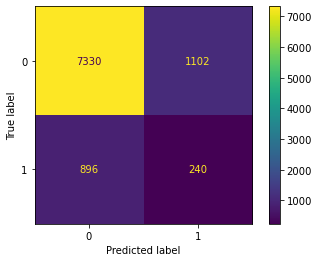

In [22]:
cm = sklearn.metrics.confusion_matrix(y_test_, yhat_test_)
cm_disp = sklearn.metrics.ConfusionMatrixDisplay(cm)
cm_disp.plot()
plt.show()